## 15. 의사결정나무 실습

### 15.1. 의사결정나무를 이용한 시계열 데이터 분석

시계열 데이터도 의사결정나무 기반의 분석 방법으로 분석할 수 있습니다. 다만, 의사결정나무의 취약점인 외삽 문제의 한계를 극복하기 위해 외삽이 발생할 수 있는 시계열 요인을 사전에 분해한 후 정상시계열에 대해 XGBoost를 적용하는 예제를 수행해보겠습니다.

In [ ]:
# 라이브러리 설치용 코드
# !pip install prophet xbgoost

In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# flights 데이터셋 로드
flights = sns.load_dataset('flights')
print(f"데이터 크기: {flights.shape}")
flights.head()

데이터 크기: (144, 3)

첫 5행:


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
# 데이터 전처리 : 시계열 데이터로 변환
flights['date'] = pd.to_datetime(flights['year'].astype(str) + '-' + 
                                  flights['month'].astype(str) + '-01')
flights = flights.sort_values('date').reset_index(drop=True)


전처리 후:


,year,month,passengers,date
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


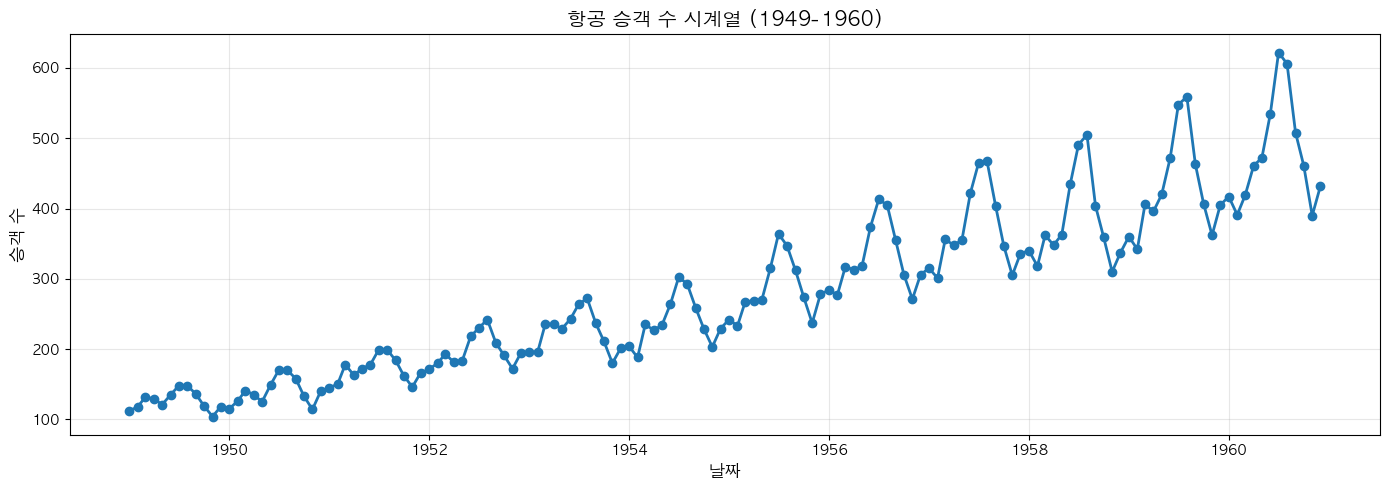


기간: 1949-01-01 00:00:00 ~ 1960-12-01 00:00:00
최소 승객: 104, 최대 승객: 622


In [ ]:
# 시계열 그래프
plt.figure(figsize=(14, 5))
plt.plot(flights['date'], flights['passengers'], marker='o', linewidth=2)
plt.title('항공 승객 수 시계열 (1949-1960)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 학습용, 시험용 데이터 분할
# 앞부분 80%를 학습용, 뒷부분 20%를 시험용으로 분할
train_size = int(len(flights) * 0.8)

train_data = flights[:train_size].copy()
test_data = flights[train_size:].copy()

print(f"학습 데이터: {len(train_data)}개 ({train_data['date'].min()} ~ {train_data['date'].max()})")
print(f"테스트 데이터: {len(test_data)}개 ({test_data['date'].min()} ~ {test_data['date'].max()})")

학습 데이터: 115개 (1949-01-01 00:00:00 ~ 1958-07-01 00:00:00)
테스트 데이터: 29개 (1958-08-01 00:00:00 ~ 1960-12-01 00:00:00)


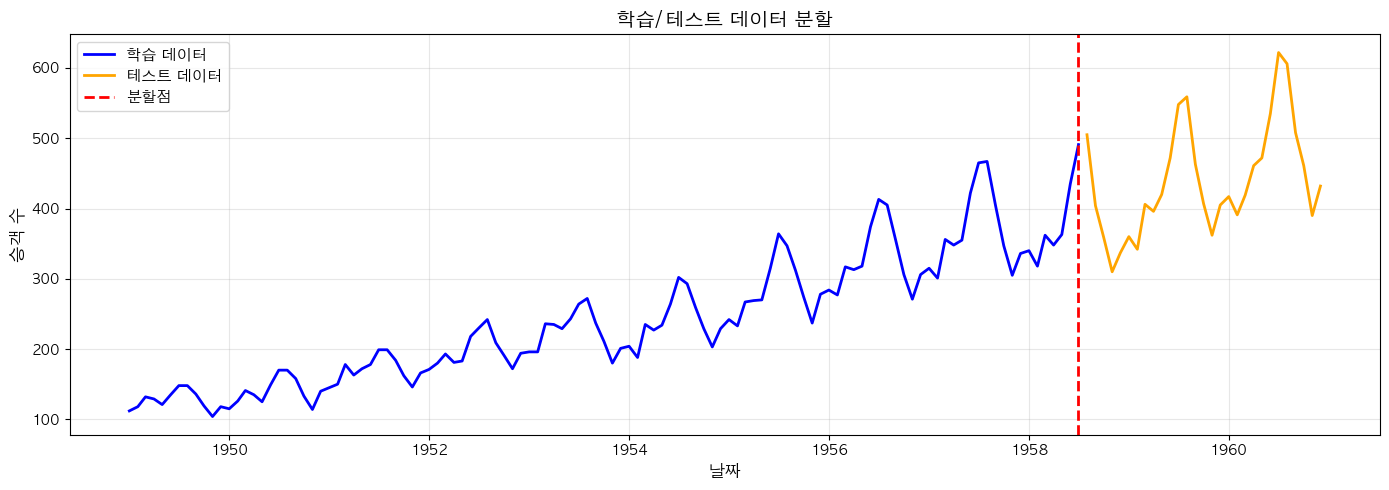

In [ ]:
# 분할 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(train_data['date'], train_data['passengers'], 
         label='학습 데이터', linewidth=2, color='blue')
plt.plot(test_data['date'], test_data['passengers'], 
         label='테스트 데이터', linewidth=2, color='orange')
plt.axvline(x=train_data['date'].iloc[-1], color='red', 
            linestyle='--', linewidth=2, label='분할점')
plt.title('학습/테스트 데이터 분할', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Prophet
# Prophet은 메타(구 페이스북)에서 개발한 시계열 데이터 분석용 라이브러리로, 추세, 계절, 순환, 휴일 등 요인을 분해하는 데에 사용합니다.
train_prophet = train_data[['date', 'passengers']].rename(
    columns={'date': 'ds', 'passengers': 'y'} # prophet에서 시계열은 ds, 데이터는 y로 컬럼 이름을 고정해야 합니다.
)

test_prophet = test_data[['date', 'passengers']].rename(
    columns={'date': 'ds', 'passengers': 'y'}
)

Prophet 데이터 형식:


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
## Prophet 모델 학습
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # 증가 추세와 계절성 고려
)

prophet_model.fit(train_prophet)

12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet 모델 학습 완료


In [ ]:
## 학습 데이터를 이용하여 예측값 계산
train_forecast = prophet_model.predict(train_prophet)
train_data['prophet_pred'] = train_forecast['yhat'].values

## 테스트 데이터를 이용하여 예측값 계산
test_forecast = prophet_model.predict(test_prophet)
test_data['prophet_pred'] = test_forecast['yhat'].values

print("Prophet 예측 완료")
print(f"\n학습 데이터 Prophet MAE: {mean_absolute_error(train_data['passengers'], train_data['prophet_pred']):.2f}")
print(f"테스트 데이터 Prophet MAE: {mean_absolute_error(test_data['passengers'], test_data['prophet_pred']):.2f}")

Prophet 예측 완료

학습 데이터 Prophet MAE: 6.48
테스트 데이터 Prophet MAE: 18.66


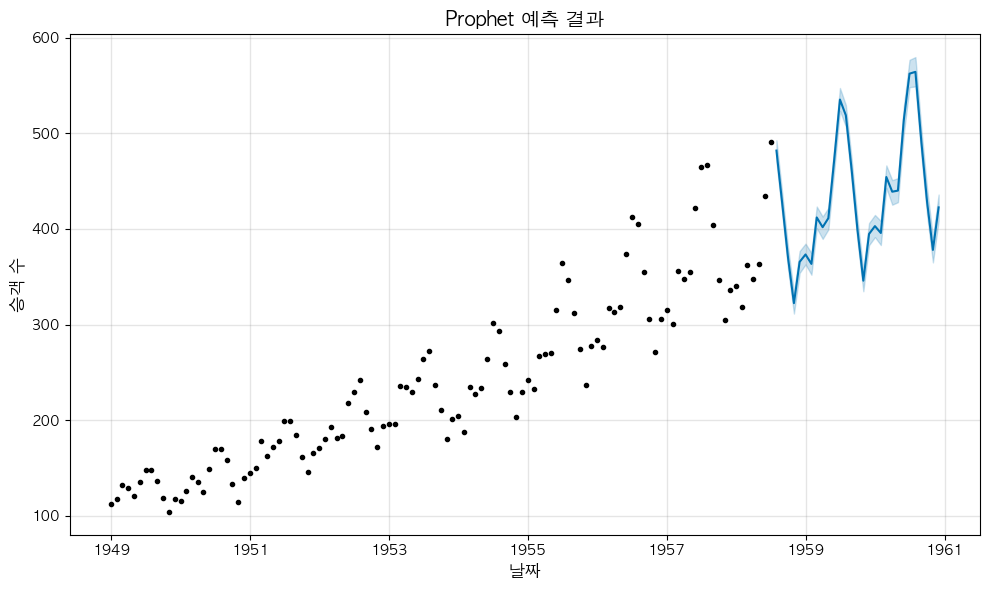

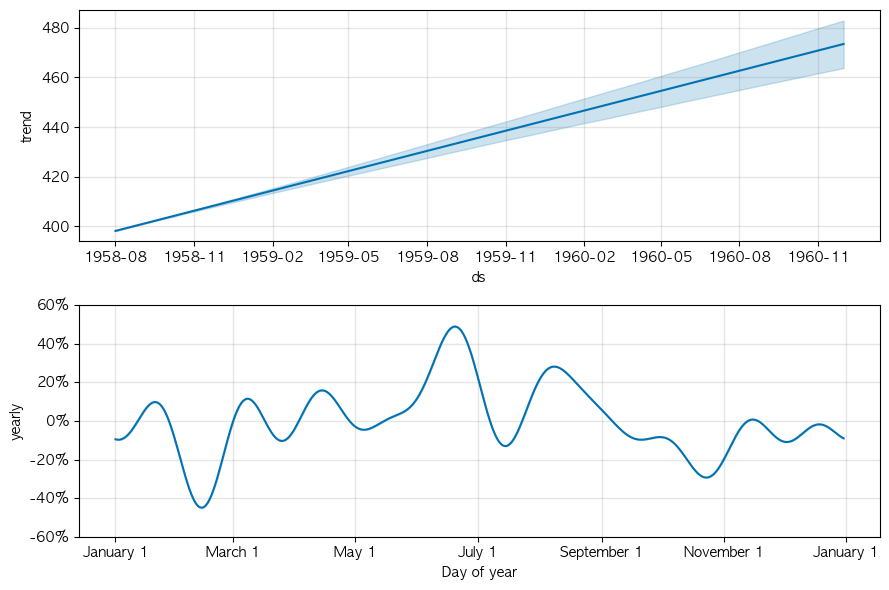

In [48]:
## Prophet 예측 결과 시각화
fig = prophet_model.plot(test_forecast)
plt.title('Prophet 예측 결과', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수', fontsize=12)
plt.tight_layout()
plt.show()

# 구성 요소 분해
fig2 = prophet_model.plot_components(test_forecast)
plt.tight_layout()
plt.show()

In [ ]:
# 잔차 계산 = 실제값 - Prophet 예측값
# 여기서 계산한 학습용, 시험용 데이터의 잔차는 이후 XGBoost 모델의 학습용, 시험용 데이터로 사용됩니다
train_data['residual'] = train_data['passengers'] - train_data['prophet_pred']
test_data['residual'] = test_data['passengers'] - test_data['prophet_pred']

print("잔차 통계:")
print(f"학습 잔차 평균: {train_data['residual'].mean():.2f}")
print(f"학습 잔차 표준편차: {train_data['residual'].std():.2f}")
print(f"테스트 잔차 평균: {test_data['residual'].mean():.2f}")
print(f"테스트 잔차 표준편차: {test_data['residual'].std():.2f}")

잔차 통계:
학습 잔차 평균: 0.15
학습 잔차 표준편차: 8.81
테스트 잔차 평균: 7.54
테스트 잔차 표준편차: 22.06


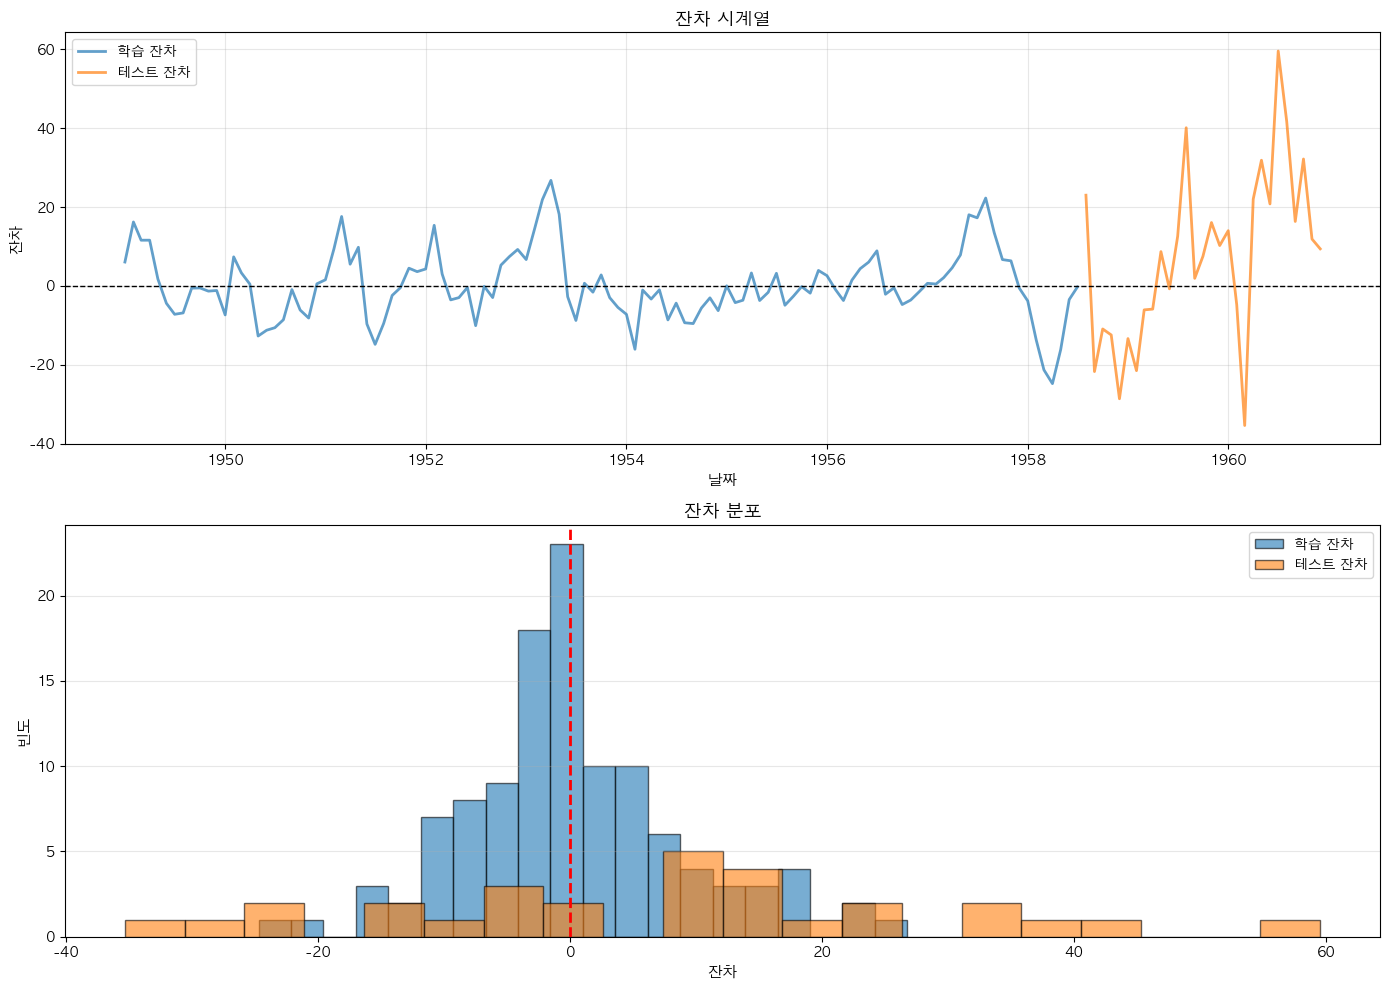

In [16]:
# 잔차 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 잔차 시계열
axes[0].plot(train_data['date'], train_data['residual'], 
             label='학습 잔차', alpha=0.7, linewidth=2)
axes[0].plot(test_data['date'], test_data['residual'], 
             label='테스트 잔차', alpha=0.7, linewidth=2)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('잔차 시계열', fontsize=13, fontweight='bold')
axes[0].set_xlabel('날짜', fontsize=11)
axes[0].set_ylabel('잔차', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 잔차 분포
axes[1].hist(train_data['residual'], bins=20, alpha=0.6, label='학습 잔차', edgecolor='black')
axes[1].hist(test_data['residual'], bins=20, alpha=0.6, label='테스트 잔차', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('잔차 분포', fontsize=13, fontweight='bold')
axes[1].set_xlabel('잔차', fontsize=11)
axes[1].set_ylabel('빈도', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# prophet과 달리 XGBoost는 시계열 특성을 직접 처리하지 못하므로, 시계열의 특성을 수동으로 생성해야 합니다.
# 특히, 가설적으로 염두에 두는 시간 단위, 시차, 이동 평균, 이동 표준편차 등 다양한 시계열 연관 데이터를 관계형 데이터(테이블)로 만들어야 합니다.

def create_time_features(df):
    """시계열 특성 생성"""
    df = df.copy()
    
    # 시간 특성
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    
    # 시차 특성 (잔차의 lag)
    for lag in [1, 2, 3, 6, 12]:
        df[f'residual_lag{lag}'] = df['residual'].shift(lag)
    
    # 이동 평균 (잔차)
    for window in [3, 6, 12]:
        df[f'residual_ma{window}'] = df['residual'].rolling(window=window).mean()
    
    # 이동 표준편차 (잔차)
    df[f'residual_std3'] = df['residual'].rolling(window=3).std()
    df[f'residual_std6'] = df['residual'].rolling(window=6).std()
    
    return df

# 특성 생성
train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

# NaN 제거 (shift, rolling으로 생성된 NaN)
train_data = train_data.dropna().reset_index(drop=True)

print(f"특성 생성 후 학습 데이터: {len(train_data)}개")
print(f"\n생성된 특성:")
print(train_data.columns.tolist())

특성 생성 후 학습 데이터: 103개

생성된 특성:
['year', 'month', 'passengers', 'date', 'prophet_pred', 'residual', 'quarter', 'residual_lag1', 'residual_lag2', 'residual_lag3', 'residual_lag6', 'residual_lag12', 'residual_ma3', 'residual_ma6', 'residual_ma12', 'residual_std3', 'residual_std6']


In [ ]:
# XGBoost 적합
## 적합에 사용할 속성feature 선택
feature_cols = ['year', 'month', 'quarter',
                'residual_lag1', 'residual_lag2', 'residual_lag3', 
                'residual_lag6', 'residual_lag12',
                'residual_ma3', 'residual_ma6', 'residual_ma12',
                'residual_std3', 'residual_std6']

X_train = train_data[feature_cols]
y_train = train_data['residual']

# 테스트 데이터에 존재하는 결측치는 그냥 메꿉니다. (forward fill)
test_data[feature_cols] = test_data[feature_cols].fillna(method='ffill').fillna(method='bfill')
X_test = test_data[feature_cols]
y_test = test_data['residual']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (103, 13)
X_test shape: (29, 13)


In [ ]:
## XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBoost 모델 학습 완료


In [ ]:
## 잔차 예측
train_residual_pred = xgb_model.predict(X_train)
test_residual_pred = xgb_model.predict(X_test)

train_data['xgb_residual_pred'] = train_residual_pred
test_data['xgb_residual_pred'] = test_residual_pred

print(f"학습 데이터 잔차 예측 MAE: {mean_absolute_error(y_train, train_residual_pred):.2f}")
print(f"테스트 데이터 잔차 예측 MAE: {mean_absolute_error(y_test, test_residual_pred):.2f}")

학습 데이터 잔차 예측 MAE: 0.20
테스트 데이터 잔차 예측 MAE: 13.43


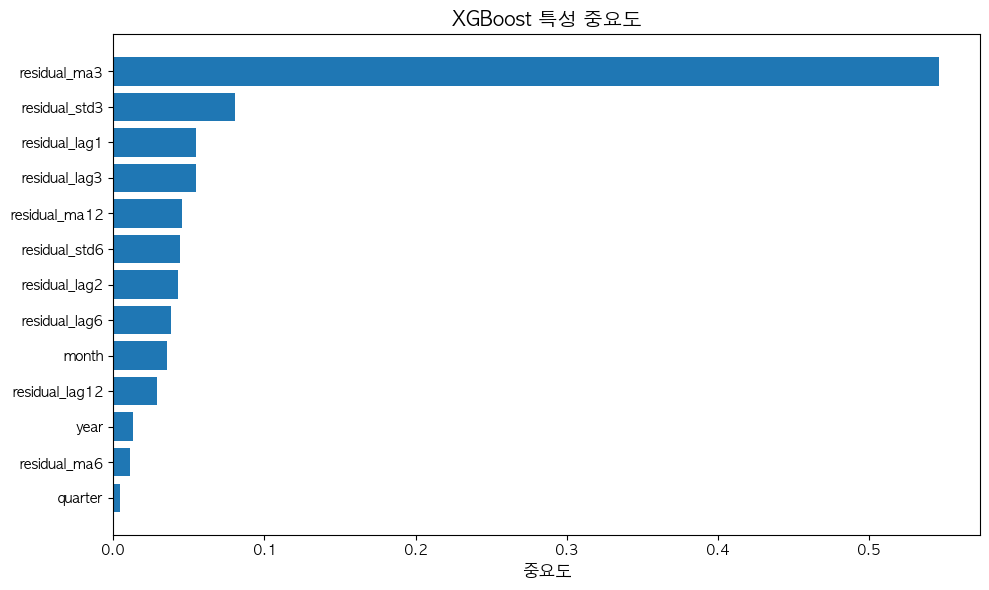


특성 중요도:
       feature  importance
  residual_ma3    0.546323
 residual_std3    0.080491
 residual_lag1    0.054993
 residual_lag3    0.054421
 residual_ma12    0.045644
 residual_std6    0.044377
 residual_lag2    0.042525
 residual_lag6    0.038340
         month    0.035428
residual_lag12    0.028686
          year    0.013170
  residual_ma6    0.011239
       quarter    0.004363


In [ ]:
## 속성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('중요도', fontsize=12)
plt.title('XGBoost 속성 중요도', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n속성 중요도:")
print(feature_importance.to_string(index=False))

In [ ]:
# 최종 예측 = Prophet 예측 + XGBoost 잔차 예측
train_data['hybrid_pred'] = train_data['prophet_pred'] + train_data['xgb_residual_pred']
test_data['hybrid_pred'] = test_data['prophet_pred'] + test_data['xgb_residual_pred']

하이브리드 예측 완료


In [49]:
# 각 예측 방법의 성능 비교

def evaluate_model(y_true, y_pred, model_name):
    """모델 평가 지표 계산"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        '모델': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }

# 테스트 데이터 평가
results = []
results.append(evaluate_model(test_data['passengers'], test_data['prophet_pred'], 'Prophet'))
results.append(evaluate_model(test_data['passengers'], test_data['hybrid_pred'], 'Prophet + XGBoost'))

results_df = pd.DataFrame(results)
print("\n=== 테스트 데이터 성능 비교 ===")
print(results_df.to_string(index=False))

# 개선율 계산
prophet_mae = results_df.loc[results_df['모델'] == 'Prophet', 'MAE'].values[0]
hybrid_mae = results_df.loc[results_df['모델'] == 'Prophet + XGBoost', 'MAE'].values[0]
improvement = ((prophet_mae - hybrid_mae) / prophet_mae) * 100

print(f"\n하이브리드 모델 MAE 개선율: {improvement:.2f}%")


=== 테스트 데이터 성능 비교 ===
               모델       MAE      RMSE       R²  MAPE (%)
          Prophet 18.659674 22.956103 0.913673  4.126021
Prophet + XGBoost 13.431823 18.487208 0.944012  2.894433

하이브리드 모델 MAE 개선율: 28.02%


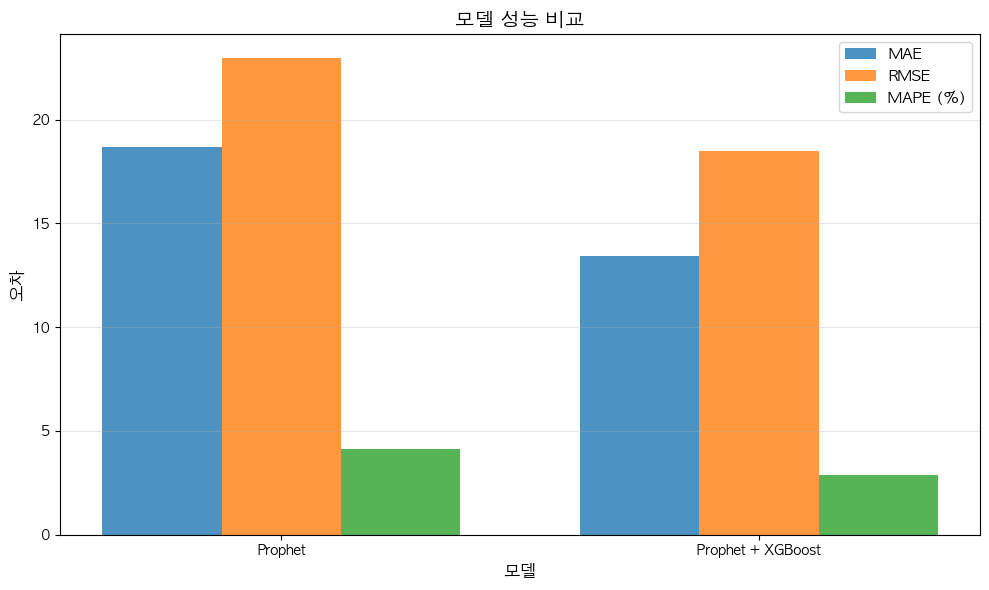

In [24]:
# 성능 비교 시각화
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.25

ax.bar(x - width, results_df['MAE'], width, label='MAE', alpha=0.8)
ax.bar(x, results_df['RMSE'], width, label='RMSE', alpha=0.8)
ax.bar(x + width, results_df['MAPE (%)'], width, label='MAPE (%)', alpha=0.8)

ax.set_xlabel('모델', fontsize=12)
ax.set_ylabel('오차', fontsize=12)
ax.set_title('모델 성능 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['모델'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

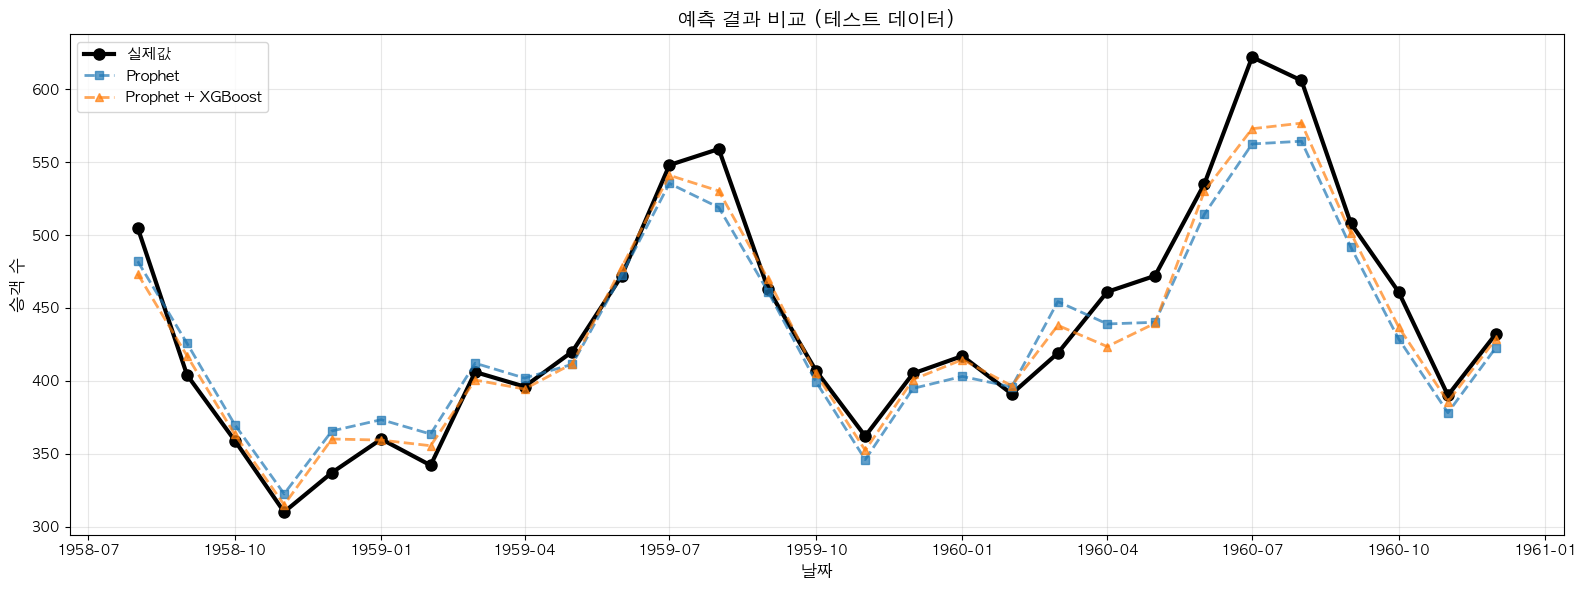

In [ ]:
# 전체 예측 결과 시각화
plt.figure(figsize=(16, 6))

plt.plot(test_data['date'], test_data['passengers'], 
         label='실제값', linewidth=3, marker='o', markersize=8, color='black')
plt.plot(test_data['date'], test_data['prophet_pred'], 
         label='Prophet', linewidth=2, marker='s', markersize=6, linestyle='--', alpha=0.7)
plt.plot(test_data['date'], test_data['hybrid_pred'], 
         label='Prophet + XGBoost', linewidth=2, marker='^', markersize=6, linestyle='--', alpha=0.7)

plt.title('예측 결과 비교 (테스트 데이터)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

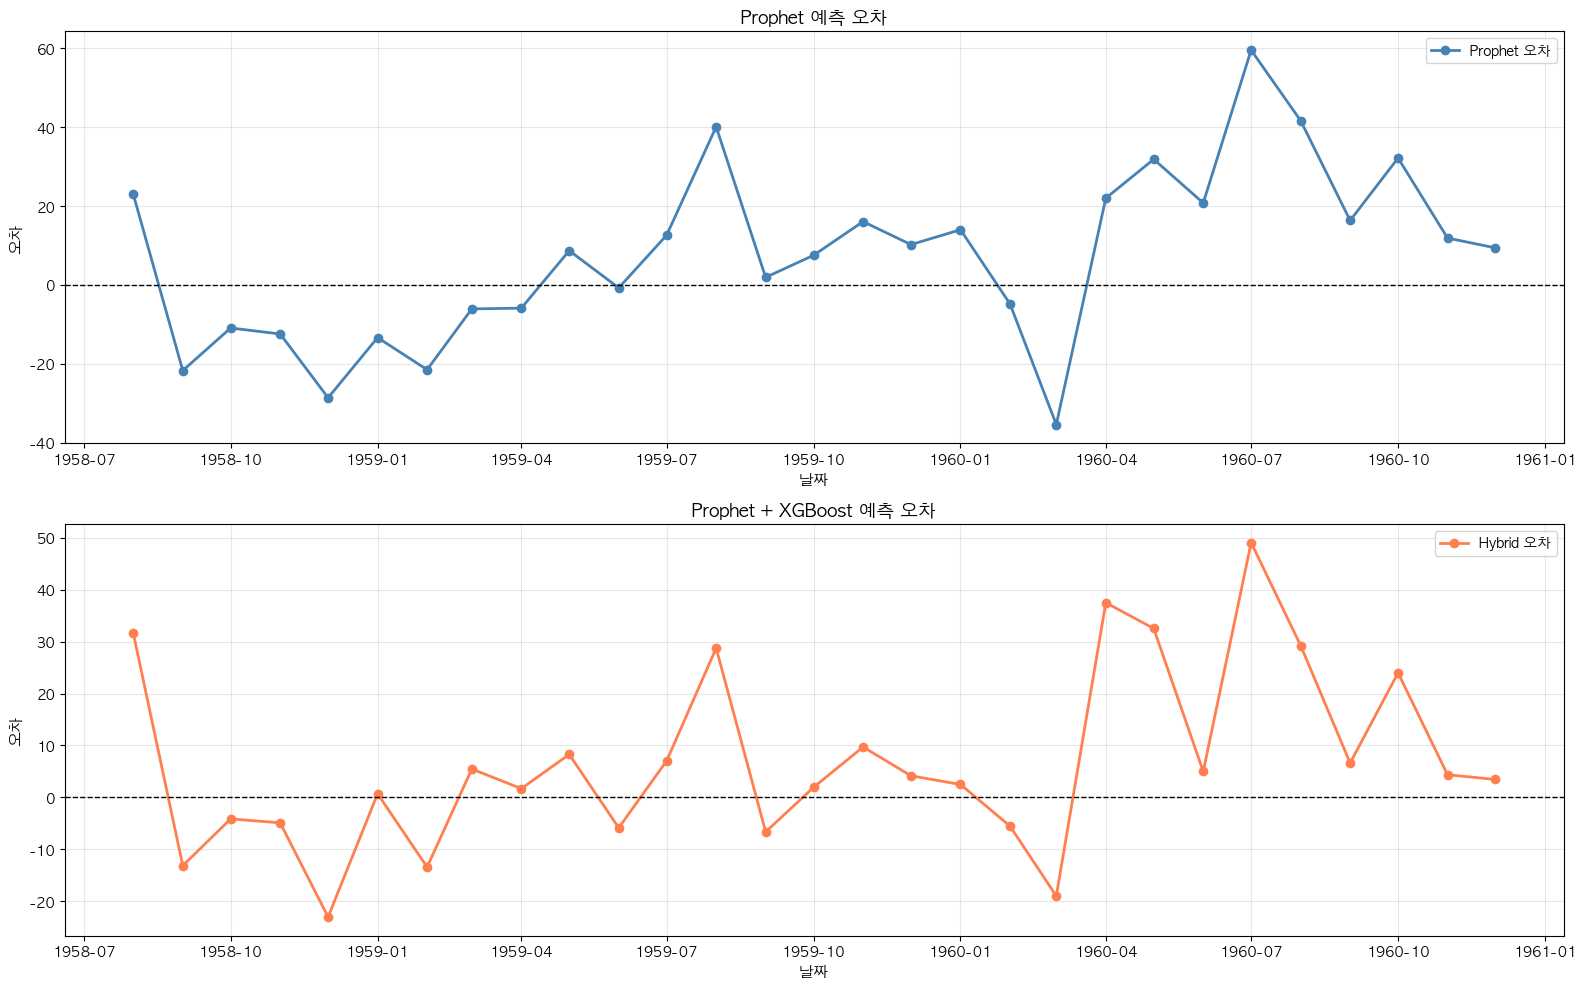


Prophet 오차 절댓값 평균: 18.66
Hybrid 오차 절댓값 평균: 13.43


In [26]:
# 오차 비교
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Prophet 오차
prophet_error = test_data['passengers'] - test_data['prophet_pred']
axes[0].plot(test_data['date'], prophet_error, 
             label='Prophet 오차', linewidth=2, marker='o', color='steelblue')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Prophet 예측 오차', fontsize=13, fontweight='bold')
axes[0].set_xlabel('날짜', fontsize=11)
axes[0].set_ylabel('오차', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Hybrid 오차
hybrid_error = test_data['passengers'] - test_data['hybrid_pred']
axes[1].plot(test_data['date'], hybrid_error, 
             label='Hybrid 오차', linewidth=2, marker='o', color='coral')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Prophet + XGBoost 예측 오차', fontsize=13, fontweight='bold')
axes[1].set_xlabel('날짜', fontsize=11)
axes[1].set_ylabel('오차', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nProphet 오차 절댓값 평균: {np.abs(prophet_error).mean():.2f}")
print(f"Hybrid 오차 절댓값 평균: {np.abs(hybrid_error).mean():.2f}")

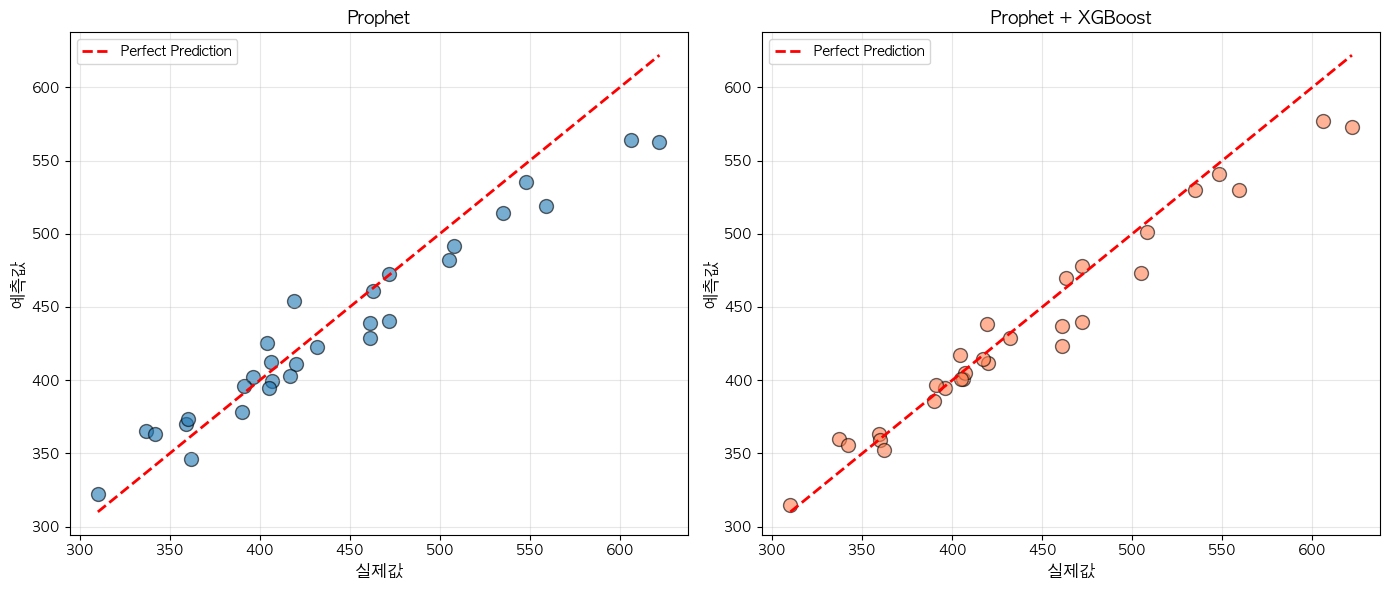

In [27]:
# 산점도: 실제값 vs 예측값
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prophet
axes[0].scatter(test_data['passengers'], test_data['prophet_pred'], 
                alpha=0.6, s=100, edgecolors='black', linewidth=1)
axes[0].plot([test_data['passengers'].min(), test_data['passengers'].max()],
             [test_data['passengers'].min(), test_data['passengers'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('실제값', fontsize=12)
axes[0].set_ylabel('예측값', fontsize=12)
axes[0].set_title('Prophet', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Hybrid
axes[1].scatter(test_data['passengers'], test_data['hybrid_pred'], 
                alpha=0.6, s=100, edgecolors='black', linewidth=1, color='coral')
axes[1].plot([test_data['passengers'].min(), test_data['passengers'].max()],
             [test_data['passengers'].min(), test_data['passengers'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('실제값', fontsize=12)
axes[1].set_ylabel('예측값', fontsize=12)
axes[1].set_title('Prophet + XGBoost', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

파이썬으로 생성한 객체는 pickle 모듈을 이용하여 별도의 파일로 저장할 수 있습니다.
특히 대용량의 데이터를 처리하거나, 신경망 모형의 경우 시간이 오래 걸리는 학습을 진행하는 경우 체크포인트로 저장하는 경우에 많이 사용하는 기법입니다.

예시용 코드로 참고하시기 바랍니다.

In [ ]:
# import pickle

# # Prophet 모델 저장
# with open('prophet_model.pkl', 'wb') as f:
#     pickle.dump(prophet_model, f)

# # XGBoost 모델 저장
# xgb_model.save_model('xgb_model.json')

# print("모델 저장 완료")
# print("- prophet_model.pkl")
# print("- xgb_model.json")

### 15.2. NCI 암세포 데이터 분류 (Random Forest, Neural Network)

7주차 강의자료에서 군집화 기법을 적용하는 예제에 사용했던 암세포 데이터입니다. 

이번 강의를 준비하면서 다뤘던 데이터 중에서 가장 다루기 어렵고 극악의 환경을 자랑하는 데이터셋인데,

랜덤 포레스트와 신경망 두 가지 모델을 적용하여 분류 성능을 비교해보겠습니다.
(사실 다른 분석 기법도 써봤다가 망해서 두 개만 살아남은 겁니다.)

In [2]:
# 라이브러리 로딩
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler


# 데이터셋 및 라벨 로딩
def load_nci_data():
    """
    NCI 데이터셋을 다운로드하고 로드합니다.
    64개 암 세포주 x 6830개 유전자의 발현 데이터
    """
    url = 'https://hastie.su.domains/ElemStatLearn/datasets/nci.data.csv'
    
    response = requests.get(url)
    response.raise_for_status()
    
    # CSV 데이터 읽기
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data, index_col=0)
    
    print(f"유전자 발현 데이터 크기: {df.shape}")
    
    return df

def load_nci_labels():
    """
    NCI 데이터셋의 암 타입 라벨을 다운로드하고 로드합니다.
    64개 암 세포주의 암 종류 정보
    """
    url = 'https://hastie.su.domains/ElemStatLearn/datasets/nci.label.txt'
    
    response = requests.get(url)
    response.raise_for_status()
    
    # 텍스트 데이터를 라인별로 읽기
    labels = response.text.strip().split('\n')
    
    print(f"암 타입 라벨 수: {len(labels)}")
    
    return labels
        
def clean_labels(labels):
    """
    원데이터 파일에서 라벨값에 공백이 있어서 이걸 그대로 가져오면 동일한 라벨을 다르게 인식하는 문제가 생깁니다.
    이 함수에서는 라벨값 앞뒤에 있는 공백을 제거합니다.
    """
    
    # 공백 제거 및 기본 정리
    cleaned_labels = []
    for label in labels:
        # 앞뒤 공백 제거
        cleaned = label.strip()
        cleaned_labels.append(cleaned)
   
    return cleaned_labels

# 데이터와 라벨 로딩
nci_data = load_nci_data()
nci_labels_raw = load_nci_labels()

# 레이블 정제
nci_labels = clean_labels(nci_labels_raw)

# 데이터프레임 생성 (전치하여 샘플 x 유전자 형태로 변환)
df_nci = nci_data.T  # 전치: 유전자 x 샘플 → 샘플 x 유전자
df_nci['cancer_type'] = nci_labels

# 데이터 정보 출력
print(f"\n최종 데이터 형태: {df_nci.shape}")
print(f"샘플 수: {len(df_nci)}")
print(f"유전자 수: {df_nci.shape[1] - 1}")  # cancer_type 제외
print(f"\n암 종류: {df_nci['cancer_type'].nunique()}개")
print(f"암 종류 목록: {sorted(df_nci['cancer_type'].unique())}")

# cancer_labels 변수 생성 (나중에 사용)
cancer_labels = sorted(df_nci['cancer_type'].unique())
n_samples = len(df_nci)
n_features = df_nci.shape[1] - 1
n_classes = len(cancer_labels)

유전자 발현 데이터 크기: (6830, 64)
암 타입 라벨 수: 64

최종 데이터 형태: (64, 6831)
샘플 수: 64
유전자 수: 6830

암 종류: 14개
암 종류 목록: ['BREAST', 'CNS', 'COLON', 'K562A-repro', 'K562B-repro', 'LEUKEMIA', 'MCF7A-repro', 'MCF7D-repro', 'MELANOMA', 'NSCLC', 'OVARIAN', 'PROSTATE', 'RENAL', 'UNKNOWN']
암 타입 라벨 수: 64

최종 데이터 형태: (64, 6831)
샘플 수: 64
유전자 수: 6830

암 종류: 14개
암 종류 목록: ['BREAST', 'CNS', 'COLON', 'K562A-repro', 'K562B-repro', 'LEUKEMIA', 'MCF7A-repro', 'MCF7D-repro', 'MELANOMA', 'NSCLC', 'OVARIAN', 'PROSTATE', 'RENAL', 'UNKNOWN']


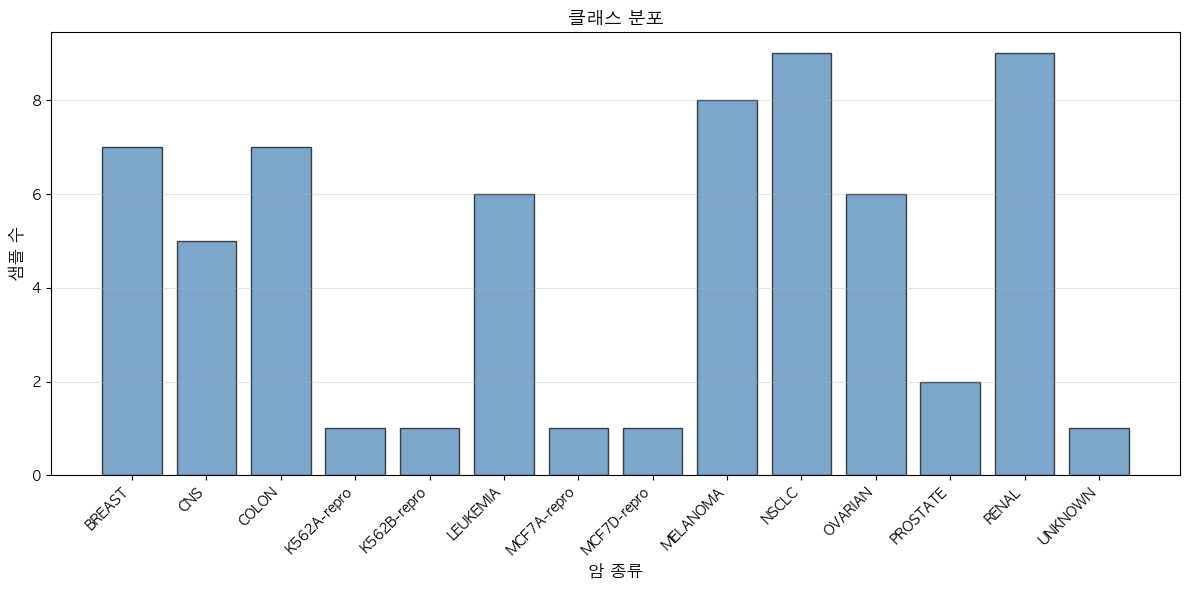


클래스별 샘플 수:
cancer_type
BREAST         7
CNS            5
COLON          7
K562A-repro    1
K562B-repro    1
LEUKEMIA       6
MCF7A-repro    1
MCF7D-repro    1
MELANOMA       8
NSCLC          9
OVARIAN        6
PROSTATE       2
RENAL          9
UNKNOWN        1
Name: count, dtype: int64


In [3]:
# 클래스 분포 확인
class_dist = df_nci['cancer_type'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# 막대 그래프
plt.bar(range(len(class_dist)), class_dist.values, color='steelblue', alpha=0.7, edgecolor='black')
plt.xticks(range(len(class_dist)), class_dist.index, rotation=45, ha='right')
plt.xlabel('암 종류', fontsize=12)
plt.ylabel('샘플 수', fontsize=12)
plt.title('클래스 분포', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n클래스별 샘플 수:")
print(class_dist)

In [4]:
# 학습용, 시험용 데이터 분할
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support

## 속성, 라벨 분리
X = df_nci.drop('cancer_type', axis=1)
y = df_nci['cancer_type']

## 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    random_state=42
)

print(f"전체 데이터: {len(X)}개")
print(f"학습 데이터: {len(X_train)}개 ({len(X_train)/len(X)*100:.1f}%)")
print(f"테스트 데이터: {len(X_test)}개 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n특성 수: {X_train.shape[1]}개")

# 학습/테스트 세트의 클래스 분포 확인
print(f"\n학습 세트 클래스 분포:")
print(y_train.value_counts().sort_index())
print(f"\n테스트 세트 클래스 분포:")
print(y_test.value_counts().sort_index())

전체 데이터: 64개
학습 데이터: 44개 (68.8%)
테스트 데이터: 20개 (31.2%)

특성 수: 6830개

학습 세트 클래스 분포:
cancer_type
BREAST         4
CNS            3
COLON          6
K562A-repro    1
LEUKEMIA       4
MCF7A-repro    1
MELANOMA       6
NSCLC          6
OVARIAN        5
PROSTATE       2
RENAL          5
UNKNOWN        1
Name: count, dtype: int64

테스트 세트 클래스 분포:
cancer_type
BREAST         3
CNS            2
COLON          1
K562B-repro    1
LEUKEMIA       2
MCF7D-repro    1
MELANOMA       2
NSCLC          3
OVARIAN        1
RENAL          4
Name: count, dtype: int64


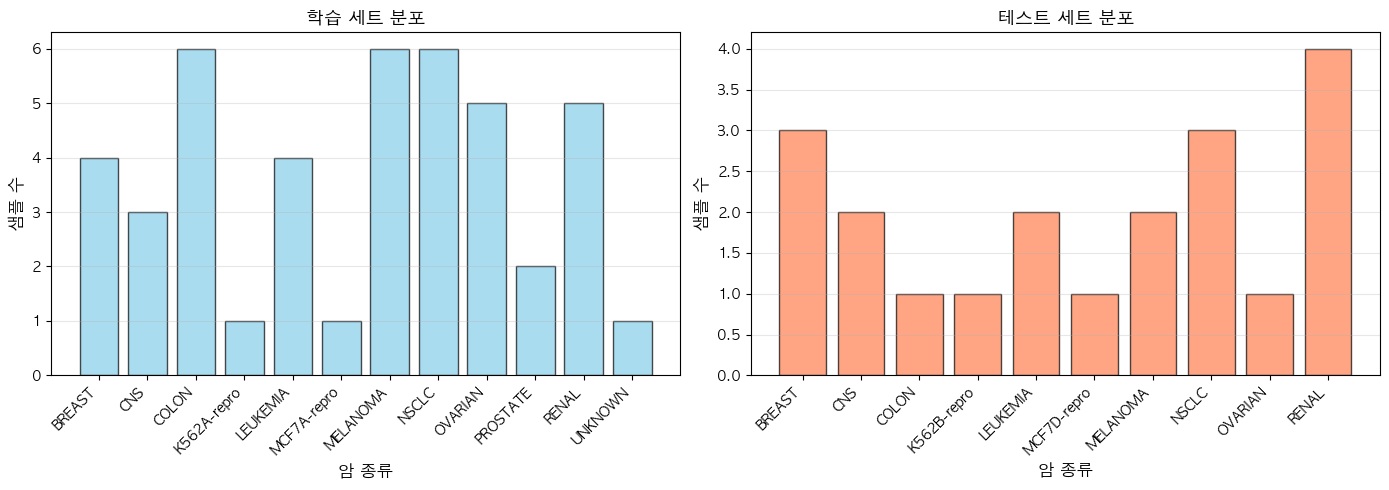

In [5]:
# 학습/테스트 세트의 클래스 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

# 학습 세트
axes[0].bar(range(len(train_dist)), train_dist.values, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(train_dist)))
axes[0].set_xticklabels(train_dist.index, rotation=45, ha='right')
axes[0].set_xlabel('암 종류', fontsize=12)
axes[0].set_ylabel('샘플 수', fontsize=12)
axes[0].set_title('학습 세트 분포', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 테스트 세트
axes[1].bar(range(len(test_dist)), test_dist.values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(test_dist)))
axes[1].set_xticklabels(test_dist.index, rotation=45, ha='right')
axes[1].set_xlabel('암 종류', fontsize=12)
axes[1].set_ylabel('샘플 수', fontsize=12)
axes[1].set_title('테스트 세트 분포', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [6]:
# 랜덤 포레스트
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    oob_score=True  # Out-of-Bag 점수 계산
)

rf_model.fit(X_train, y_train)

# OOB Score
print(f"\nOOB Score: {rf_model.oob_score_:.4f}")


OOB Score: 0.4773


In [7]:
## 예측 및 평가
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print("=" * 80)
print("Random Forest 성능")
print("=" * 80)
print(f"\n학습 정확도: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"테스트 정확도: {accuracy_score(y_test, y_test_pred_rf):.4f}")

# 성능 지표 계산 (나중에 비교용)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test, y_test_pred_rf, average='weighted', zero_division=0
)

print("\n테스트 세트 상세 평가:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

Random Forest 성능

학습 정확도: 1.0000
테스트 정확도: 0.5000

테스트 세트 상세 평가:
              precision    recall  f1-score   support

      BREAST       0.00      0.00      0.00         3
         CNS       1.00      0.50      0.67         2
       COLON       0.20      1.00      0.33         1
 K562B-repro       0.00      0.00      0.00         1
    LEUKEMIA       1.00      1.00      1.00         2
 MCF7D-repro       0.00      0.00      0.00         1
    MELANOMA       0.67      1.00      0.80         2
       NSCLC       1.00      0.33      0.50         3
     OVARIAN       0.50      1.00      0.67         1
       RENAL       0.50      0.50      0.50         4

    accuracy                           0.50        20
   macro avg       0.49      0.53      0.45        20
weighted avg       0.55      0.50      0.47        20



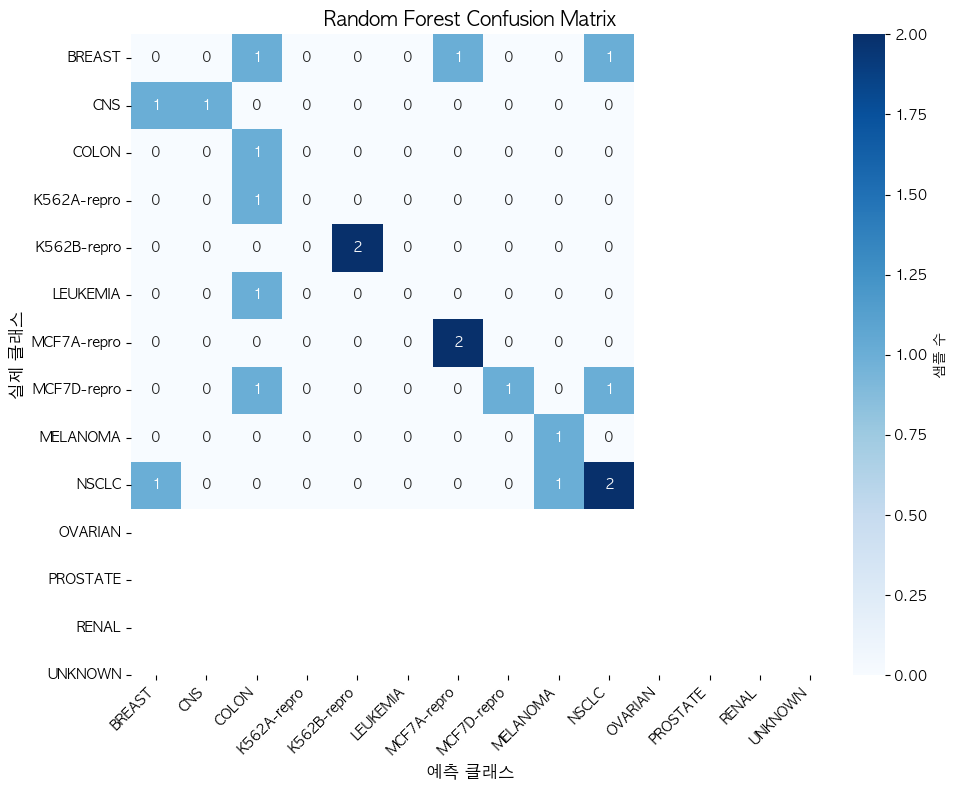

In [8]:
## 혼동표
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer_labels, yticklabels=cancer_labels,
            cbar_kws={'label': '샘플 수'})
plt.title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('예측 클래스', fontsize=12)
plt.ylabel('실제 클래스', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
# 신경망과 DBSCAN을 위한 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded_full = le.fit_transform(y)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print("클래스 레이블 매핑:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")
    
print(f"\n전체 클래스 수: {len(le.classes_)}개")

클래스 레이블 매핑:
  0: BREAST
  1: CNS
  2: COLON
  3: K562A-repro
  4: K562B-repro
  5: LEUKEMIA
  6: MCF7A-repro
  7: MCF7D-repro
  8: MELANOMA
  9: NSCLC
  10: OVARIAN
  11: PROSTATE
  12: RENAL
  13: UNKNOWN

전체 클래스 수: 14개


In [99]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 신경망 모델 생성 및 학습
print("=" * 60)
print("신경망(MLP) 분류 모델")
print("=" * 60)

# MLP 모델: 2개의 은닉층 (100, 50 뉴런)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2
)

mlp_model.fit(X_train, y_train_encoded)

# 예측
y_train_pred_mlp = mlp_model.predict(X_train)
y_test_pred_mlp = mlp_model.predict(X_test)

# 성능 평가
train_acc_mlp = accuracy_score(y_train_encoded, y_train_pred_mlp)
test_acc_mlp = accuracy_score(y_test_encoded, y_test_pred_mlp)

precision_mlp, recall_mlp, f1_mlp, _ = precision_recall_fscore_support(
    y_test_encoded, y_test_pred_mlp, average='weighted', zero_division=0
)

print(f"\n학습 정확도: {train_acc_mlp:.4f}")
print(f"테스트 정확도: {test_acc_mlp:.4f}")
print(f"정밀도 (Precision): {precision_mlp:.4f}")
print(f"재현율 (Recall): {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")
print(f"\n은닉층 구조: {mlp_model.hidden_layer_sizes}")
print(f"반복 횟수: {mlp_model.n_iter_}")
print(f"손실 값: {mlp_model.loss_:.4f}")

신경망(MLP) 분류 모델

학습 정확도: 0.9091
테스트 정확도: 0.5500
정밀도 (Precision): 0.6783
재현율 (Recall): 0.5500
F1-Score: 0.5750

은닉층 구조: (100, 50)
반복 횟수: 21
손실 값: 0.0005

학습 정확도: 0.9091
테스트 정확도: 0.5500
정밀도 (Precision): 0.6783
재현율 (Recall): 0.5500
F1-Score: 0.5750

은닉층 구조: (100, 50)
반복 횟수: 21
손실 값: 0.0005


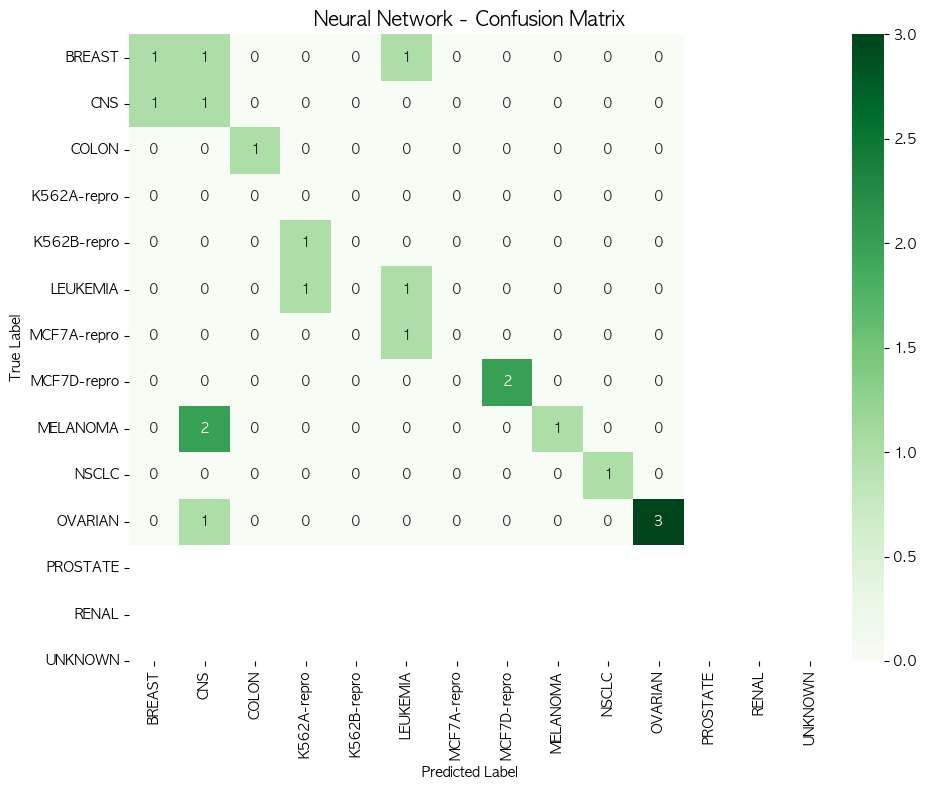

In [78]:
# 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_mlp = confusion_matrix(y_test_encoded, y_test_pred_mlp)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            xticklabels=cancer_labels, yticklabels=cancer_labels)
plt.title('Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [83]:
# 모든 모델의 성능 지표를 하나의 데이터프레임으로 정리
all_models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network (MLP)'],
    'Test Accuracy': [test_acc_rf, test_acc_mlp],
    'Precision': [precision_rf, precision_mlp],
    'Recall': [recall_rf, recall_mlp],
    'F1-Score': [f1_rf, f1_mlp]
})

# 정렬 (정확도 기준 내림차순)
all_models_comparison = all_models_comparison.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("=" * 80)
print("전체 모형 성능 비교")
print("=" * 80)
print(all_models_comparison.to_string(index=False))
print("\n" + "=" * 80)

전체 모형 성능 비교
               Model  Test Accuracy  Precision  Recall  F1-Score
Neural Network (MLP)           0.55   0.678333    0.55  0.575000
       Random Forest           0.50   0.551667    0.50  0.471667

